# Data preparation

En este documento se van a preparar diferentes altenativas de preparación de datos para encontrar la alternativa que mejor funciona durante la fase de construcción de modelos predictivos.

In [1]:
import pandas as pd
pd.set_option('max_columns', 0) #Elimina el máximo de columnas en la visualización
import time
import os
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16)) #Aumenta el tamaño de las figuras
import seaborn as sns
import numpy as np
from datetime import datetime

<Figure size 1152x1152 with 0 Axes>

## Alternativa 1: Todas las variables

En este caso nos vamos a quedar con todas las variables disponibles.

In [7]:
# Cargamos los datos
subset1 = pd.read_csv('../datasets/water_pump/sensor.csv')
subset1[subset1['machine_status']=='RECOVERING'] = 'BROKEN'
# Eliminamos los datos de sensor 15 que solo contienen valores nulos y del indice autoincremental
subset1.drop('sensor_15',axis=1,inplace=True)
subset1.drop('Unnamed: 0',axis=1,inplace=True)
# Sustituimos los valores nulos del resto del resto del dataset por el promedio
for column in subset1.drop(['timestamp','machine_status'], axis=1).columns:
    subset1[column].fillna(subset1[column].mean(),inplace=True)
    

sensor_01


TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [5]:
# subset1.head()
subset1.machine_status.value_counts()

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51'],
      dtype='object')

## Alternativa 2: Variables más correladas con el objetivo

En este caso calculamos la correlación entre las variables y el objetivo para encontrar las que guardan una relación más directa. De estas vamos a escoger las variables que tienen una correlación superior a 0.7

In [ ]:
# Cargamos los datos
subset2 = pd.read_csv('../datasets/water_pump/sensor.csv')
# Eliminamos los datos de sensor 15 que solo contienen valores nulos y del indice autoincremental
subset2.drop('sensor_15',axis=1,inplace=True)
subset2.drop('Unnamed: 0',axis=1,inplace=True)
# Sustituimos los valores nulos del resto del resto del dataset por el promedio
#discretizamos la variable objetivo
subset2['machine_status'] =subset2['machine_status'].astype('category').cat.codes
#obtener correlación entre predictores y target
correlation = subset2.drop(columns=['timestamp']).corrwith(subset2['machine_status'])
features_cor = correlation[correlation.abs()>0.7].index
subset2 = pd.concat([subset2['timestamp'],subset2[features_cor]], axis=1)

In [32]:
subset2.head()

,timestamp,sensor_00,sensor_02,sensor_04,sensor_06,sensor_10,sensor_11,sensor_12,sensor_50,machine_status
0,2018-04-01 00:00:00,2.465394,53.2118,634.3750,13.41146,37.22740,47.52422,31.11716,243.0556,1
1,2018-04-01 00:01:00,2.465394,53.2118,634.3750,13.41146,37.22740,47.52422,31.11716,243.0556,1
2,2018-04-01 00:02:00,2.444734,53.2118,638.8889,13.32465,37.86777,48.17723,32.08894,241.3194,1
3,2018-04-01 00:03:00,2.460474,53.1684,628.1250,13.31742,38.57977,48.65607,31.67221,240.4514,1
4,2018-04-01 00:04:00,2.445718,53.2118,636.4583,13.35359,39.48939,49.06298,31.95202,242.1875,1


## Alternativa 3: Analisis de componentes principales

En este caso vamos a realizar un análisis de componentes principales para ver que variables representan una mayor varianza dentro del conjunto de datos. Como se trata de analizar la varianza y estamos trabajando con valores que tiene diferentes magnitudes, el primer paso será normalizar los valores, para que las unidades en la que se expresan las variables no influyan en el análisis.

<function matplotlib.pyplot.show(*args, **kw)>

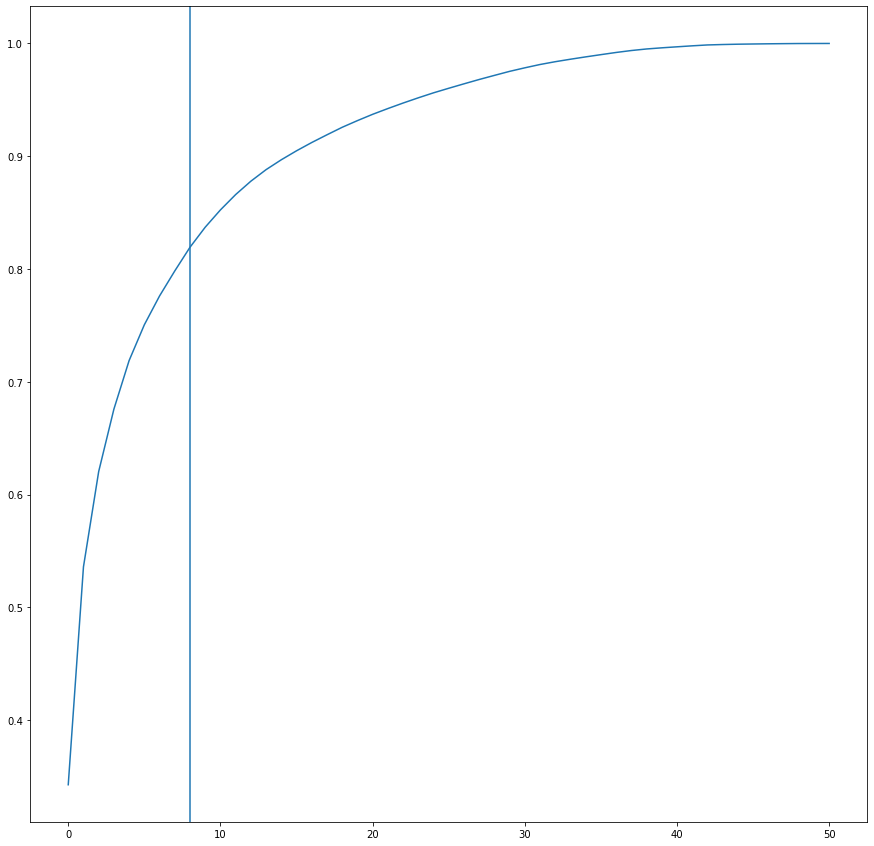

In [50]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

subset3 = pd.read_csv('../datasets/water_pump/sensor.csv')
# Eliminamos los datos de sensor 15 que solo contienen valores nulos y del indice autoincremental
subset3.drop('sensor_15',axis=1,inplace=True)
subset3.drop('Unnamed: 0',axis=1,inplace=True)
# Sustituimos los valores nulos del resto del resto del dataset por el promedio
non_numeric = ['machine_status','timestamp']
for column in subset3.drop(non_numeric,axis=1).columns:
    subset3[column].fillna(subset3[column].mean(),inplace=True)
X = subset3.drop(non_numeric,axis=1)
pca = PCA()
#Normalizamos las variables antes de realizar el análisis de componentes principales para evitar que la magnitud de las
#variables influya en el resultado
X = StandardScaler().fit_transform(X) 
X_new = pca.fit_transform(X)

cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])
cum_var = pd.Series(cum_explained_var)
cum_var.plot(kind='line',
             figsize=(15,15))
plt.axvline(x=8)
plt.show

Podemos ver que con 8 variables (mismo numero escogido en el caso de la correlacion) somos capaces representar cerca del 80% de la varianza del cojunto de datos, por lo que, en este caso nos quedaremos con esas variables, y crearemos un pipeline para que cada nuevo valor que llegue sea sometido a esa transformación.

In [55]:
pca = PCA(n_components=8)
X_new = pca.fit_transform(X)
subset3_fin = pd.concat([pd.DataFrame(data=X_new,columns=['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8']),subset3.machine_status],axis=1)
subset3_fin.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,machine_status
0,-0.010524,0.776836,-0.522598,-0.782775,-1.943779,1.534485,-1.129979,-0.168141,NORMAL
1,-0.010524,0.776836,-0.522598,-0.782775,-1.943779,1.534485,-1.129979,-0.168141,NORMAL
2,-0.151425,0.782445,-0.493741,-0.842870,-2.105337,1.502015,-1.125956,-0.024630,NORMAL
3,-0.151886,0.816480,-0.541563,-0.971446,-2.013140,1.584471,-1.166866,-0.002001,NORMAL
4,-0.106250,0.929111,-0.407697,-1.025287,-1.989730,1.509052,-1.168358,-0.138414,NORMAL


## Alternativa 4: Select k-best

En este caso vamos a aplicar una transformación del paquete sklearn que selecciona las mejores variables de un conjunto de datos basandose en una medida de error indicada por el usuario. Según lo visto en la literatura, la que mejor funciona en estas tareas es la función chi2. Mantendremos también las 8 variables como en los otros casos.

In [59]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

subset4 = pd.read_csv('../datasets/water_pump/sensor.csv')
# Eliminamos los datos de sensor 15 que solo contienen valores nulos y del indice autoincremental
subset4.drop('sensor_15',axis=1,inplace=True)
subset4.drop('Unnamed: 0',axis=1,inplace=True)
# Sustituimos los valores nulos del resto del resto del dataset por el promedio
non_numeric = ['machine_status','timestamp']
for column in subset4.drop(non_numeric,axis=1).columns:
    subset4[column].fillna(subset4[column].mean(),inplace=True)
X_kbest,y_kbest = subset4.drop(non_numeric,axis=1), subset4.machine_status
k_best = SelectKBest(chi2, k=8)
X_new_kbest = k_best.fit_transform(X_kbest, y_kbest)

In [63]:
subset4_fin = pd.concat([pd.DataFrame(data=X_new_kbest),subset3.machine_status],axis=1)
subset4_fin.head()

,0,1,2,3,4,5,6,7,machine_status
0,634.3750,37.22740,47.52422,31.11716,785.1935,682.8125,157.9861,243.0556,NORMAL
1,634.3750,37.22740,47.52422,31.11716,785.1935,682.8125,157.9861,243.0556,NORMAL
2,638.8889,37.86777,48.17723,32.08894,778.5734,721.8750,155.9606,241.3194,NORMAL
3,628.1250,38.57977,48.65607,31.67221,779.5091,754.6875,155.9606,240.4514,NORMAL
4,636.4583,39.48939,49.06298,31.95202,785.2307,766.1458,158.2755,242.1875,NORMAL
